The output of this should be an amat matrix (i.e., a matrix collecting value of the a vector from the initial $a_0$ state to $a_N$ state, where $N$ is the number of time steps)

This goal is equal to solving the forward TDSE problem given some initial state $\psi_0$ and some potential $v(x, t)$.

In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:]
    # that can be strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [3]:
# set up computational parameters (such as computational region)

# set radius of spatial domain
l = 16

# set real space grid, used for plotting
# this has to be even for the comparison of
# of methods for converting the true potential to
# the Fourier basis to work.
nx = 1024

# dx is needed to perform norm check of training data
xvec, dx = np.linspace(-l, l, nx, retstep=True)

# set number of Fourier basis
nF = 128

# matrix for converting Fourier basis coefficients to real space values
nvec = np.arange(-nF, nF+1) # nvec=-nfb,...,0,...,nfb
Fmat = (1 / np.sqrt(2 * l)) * np.exp(1j * np.pi * np.outer(nvec, xvec) / l)

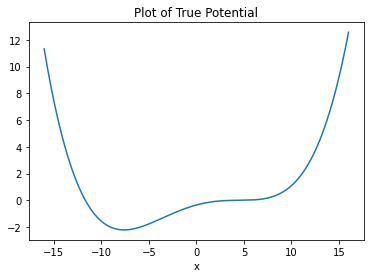

In [4]:
# define potential used to evolve the system

def v(x):
    # dimensionless quantum harmonic oscillator potential
    # return 0.5 * x**2
    # rescaled symmetric double well potential
    # return 0.0025*(x**2 - 25)**2
    # scaled asymmetric double well potential
    return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential at xvec real space grid points
vtruvec = v(xvec)

# plot true potential
plt.plot(xvec, vtruvec)
plt.title('Plot of True Potential')
plt.xlabel('x')
plt.show()

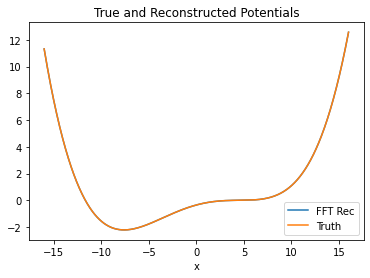

Rel Norm Diff of Rec (should be close to zero):
3.232809696826269e-16


In [11]:
# transform true potential to Fourier basis

# Fres can be adjusted to improve the Fourier basis resolution
# if we set Fres = 1, then Fsample = 2*nfb, which is the
# Nyquist frequency
# Fres = 100
# Fsample = Fres * 2 * nF
# Fxvec = np.linspace(-l, l, Fsample + 2)
# Fvtruvec = np.fft.rfft(v(Fxvec), norm='forward')
# Fvtruvecrec1 = np.fft.irfft(Fvtruvec, norm='forward')
Fvvec = np.fft.rfft(vtruvec, norm='forward')
Fvvecrec = np.fft.irfft(Fvvec, norm='forward')

# plot potentials
plt.plot(xvec, Fvvecrec, '-', label='FFT Rec')
plt.plot(xvec, vtruvec, label='Truth')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff of Rec (should be close to zero):', nl.norm(vtruvec - Fvvecrec) / nl.norm(vtruvec), sep='\n')

# compute Fourier basis representation of potential
# using a quadrature method
# FFT method gives reconstructions with a RND on the
# order of 1e-16, while the quadrature method is on
# order of 1e-4, so the FFT is more accurate
# def vintegrand(x):
#     return v(x) * np.exp(-1j * np.pi * nvec * x / l) / np.sqrt(2 * l)
# vquadrtn = si.quad_vec(vintegrand, -l, l)[0]
# print(vquadrtn.shape)
# print(Fmat.shape)
# Fvtruvecrec2 = vquadrtn @ Fmat

# plot potentials
# plt.plot(Fxvec, Fvtruvecrec1, '-', label='FFT')
# plt.plot(xvec, Fvtruvecrec2.real, '-', label='quad real')
# plt.plot(xvec, Fvtruvecrec2.imag, '-', label='quad imag')
# plt.plot(xvec, vtruvec, label='Truth')
# plt.title('True and Reconstructed Fourier Basis Potentials')
# plt.xlabel('x')
# plt.legend()
# plt.show()

# print('Rel Norm Diff FFT:', nl.norm(vtruvec - Fvtruvecrec1) / nl.norm(vtruvec))
# print('Rel Norm Diff quad:', nl.norm(vtruvec - Fvtruvecrec2) / nl.norm(vtruvec))

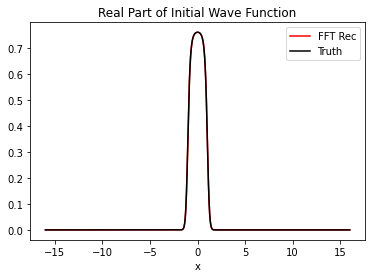

Rel Norm Diff FFT: 2.756158104341385e-16


In [20]:
# define initial state and transform to Fourier basis

def psi0(x):
    # rounded box function
    return 1.0 + np.tanh((1 - x**2)/0.5)
    # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
    # parabolic pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
    # hyperbolic secant squared
    # return (np.cosh(x))**(-2)
    # Laplace
    # return np.exp(-np.abs(x))

def mknormpsifn(psifn):
    # compute psi normalization term,
    # this is a constant given some psi
    psiprobintegrand = lambda x: np.abs(psifn(x))**2
    normterm = np.sqrt(si.quad(psiprobintegrand, a=-l, b=l)[0])

    # define function for computing normalized psi
    # via scipy.integrate methods
    def normpsifn(x):
        return psifn(x)/normterm

    return normpsifn

normpsi0fn = mknormpsifn(psi0)

# vector of the normalized psi0 function sampled on the
# real space grid, "Truth"
normpsi0truvec = normpsi0fn(xvec)

# compute the Fourier basis representation of the
# normalized psi0 function using FFT method
Fnormpsi0vec = np.fft.rfft(normpsi0truvec, norm='forward')
Fnormpsi0vecrec = np.fft.irfft(Fnormpsi0vec, norm='forward')
# Fnormpsi0vecrec1 = np.fft.irfft(Fnormpsi0vec, norm='forward')

# plot the real port of the normalized psi0
plt.plot(xvec, Fnormpsi0vecrec.real, 'r', label="FFT Rec")
plt.plot(xvec, normpsi0truvec.real, 'k', label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff FFT:', nl.norm(normpsi0truvec - Fnormpsi0vecrec) / nl.norm(normpsi0truvec))

# compute the Fourier basis representation of the
# normalized psi0 function using a scipy.integrate method
# this method produced a reconstruction who's relative
# norm difference ranged from 1e-2 to 1e-11.
# The FFT method on the other hand was always of the
# order 1e-16, so that is the method I will use
# normpsi0integrand = lambda x: np.exp(-1j * np.pi * nvec * x / l) / np.sqrt(2 * l) * normpsi0fn(x)
# normpsi0quadrtn = si.quad_vec(normpsi0integrand, -l, l)[0]
# print(normpsi0quadrtn.shape)
# print(Fmat.shape)
# Fnormpsi0vecrec2 = normpsi0quadrtn @ Fmat

# plot the real port of the normalized psi0
# plt.plot(xvec, Fnormpsi0vecrec1.real, 'r', label="Quad Rec")
# plt.plot(xvec, Fnormpsi0vecrec2.real, 'b', label="FFT Rec")
# plt.plot(xvec, normpsi0truvec.real, 'k', label="Truth")
# plt.title('Real Part of Initial Wave Function')
# plt.xlabel('x')
# plt.legend()
# plt.show()

# print('Rel Norm Diff FFT:', nl.norm(normpsi0truvec - Fnormpsi0vecrec1) / nl.norm(normpsi0truvec))
# print('Rel Norm Diff quad:', nl.norm(normpsi0truvec - Fnormpsi0vecrec2) / nl.norm(normpsi0truvec))

In [ ]:
# solve the forward problem and generate amat

In [ ]:
# store computed amat to disk